# SEQ2SEQ implemented as in DILATE (2020)

In [1]:
%config IPCompleter.greedy=True

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datasets import Traffic, ECG5000, split_dataset
from seq2seq_dilate import EncoderRNN, DecoderRNN, NetGRU, train_model
from metrics import tdi_tdm, squared_error, absolute_error

In [2]:
def plot_result(train, test, forecast):
    x = np.arange(train.shape[0] + test.shape[0])
    l = len(train)
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 3))
    axs[0].plot(x[:l], train, c='blue')
    axs[0].plot(x[l:], test, c='red')
    axs[0].plot(x[l:], forecast, c='green')
    axs[0].set_title(f"Prediction")
    
    axs[1].plot(x[l:], squared_error(test, forecast))
    axs[1].set_title(f"Squared errors")
    
    axs[2].plot(x[l:], absolute_error(test, forecast))
    axs[2].set_title(f"Absolute errors")
    plt.tight_layout()
    plt.show()

In [3]:
def predict_on_batch(model, test_loader, n):
    batch_seq, batch_target = next(iter(test_loader))
    batch_seq, batch_target = batch_seq.type(torch.float32).to(device), batch_target.type(torch.float32).to(device)
    
    model.eval()
    batch_forecast = gru_net(batch_seq)
    
    for i in range(0, n):
        seq = batch_seq.detach().cpu().numpy()[i, :, :]
        target = batch_target.detach().cpu().numpy()[i, :, :]
        forecast = batch_forecast.detach().cpu().numpy()[i, :, :]

        plot_result(seq, target, forecast)
        print("(TDI, TDM): ", tdi_tdm(target, forecast))

# Seq2Seq on ECG5000

DILATE GRU: 100%|████████████████████████████████████████████████| 20/20 [01:30<00:00,  4.51s/epoch, train_loss=0.0177]


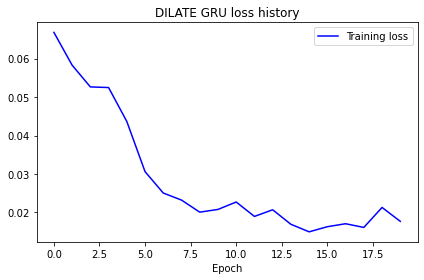

In [4]:
# Parameters
window = 84
horizon = 56
batch_size = 16
epochs = 20
lr = 0.01
 
# Load data
ecg_train = ECG5000("./data/ECG5000/ECG5000_TRAIN.tsv", window, horizon)
ecg_test = ECG5000("./data/ECG5000/ECG5000_TEST.tsv", window, horizon)
ecg_train_loader = torch.utils.data.DataLoader(ecg_train, batch_size=batch_size, shuffle=True, drop_last=True)
ecg_test_loader = torch.utils.data.DataLoader(ecg_train, batch_size=batch_size, shuffle=True, drop_last=True)

# Build model
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, fc_units=16, output_size=1).to(device)
gru_net = NetGRU(encoder, decoder, horizon, device).to(device)
optimizer = torch.optim.Adam(gru_net.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

# Train
train_model(gru_net, optimizer, loss_fn, ecg_train_loader, epochs=epochs)

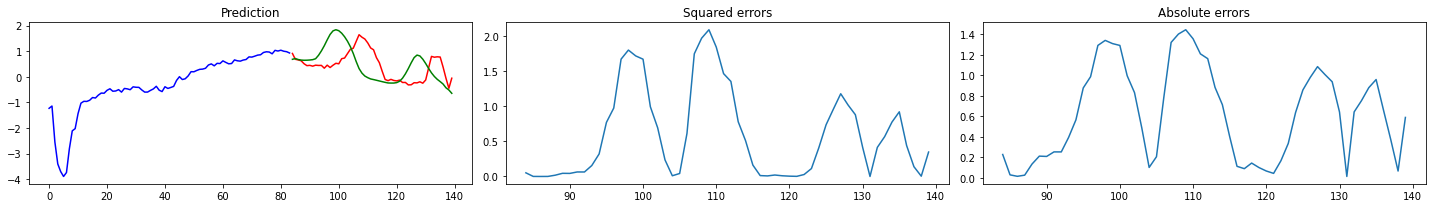

(TDI, TDM):  (0.22225765306122447, -0.9856527977044476)


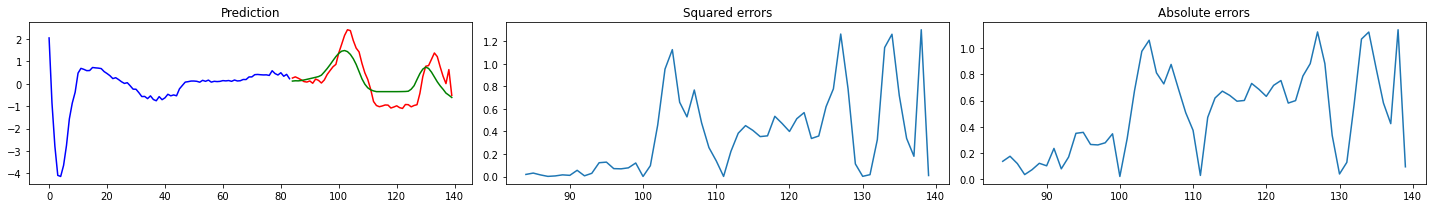

(TDI, TDM):  (0.10459183673469387, -0.9634146341463414)


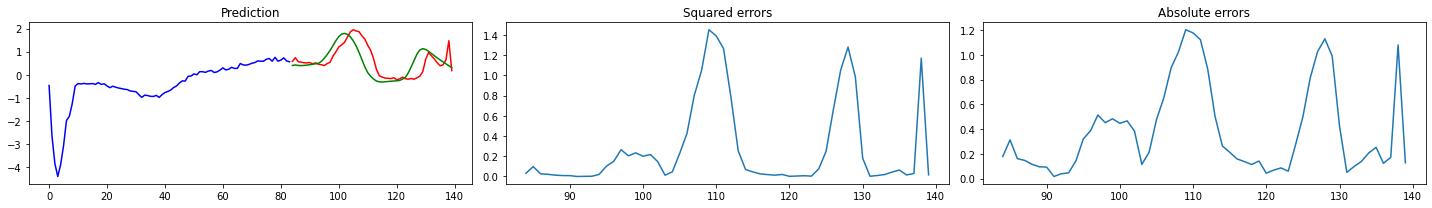

(TDI, TDM):  (0.12021683673469387, -0.9204244031830239)


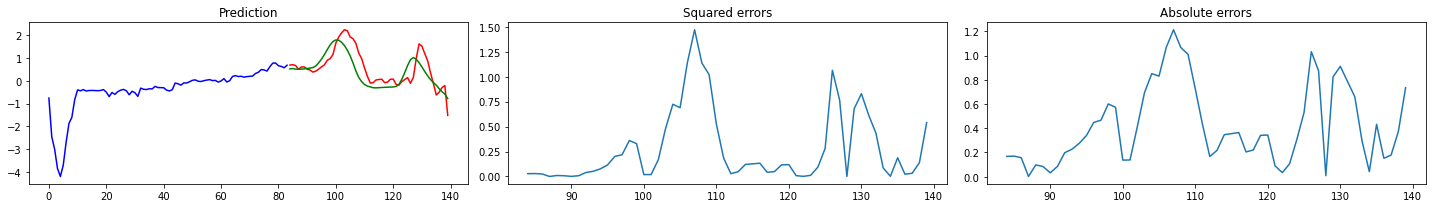

(TDI, TDM):  (0.12372448979591835, -0.9587628865979382)


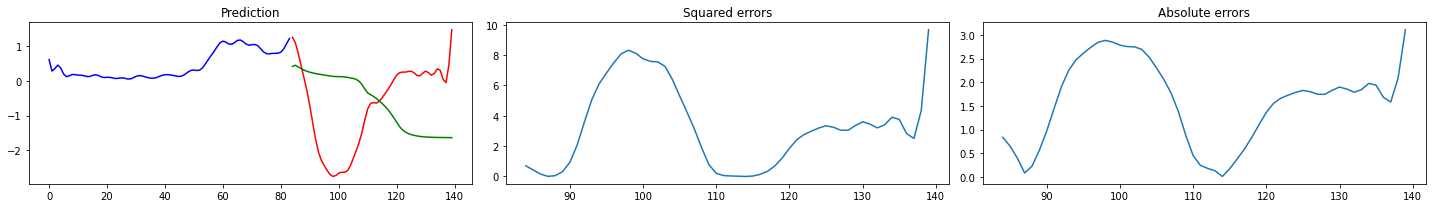

(TDI, TDM):  (0.3529974489795918, 0.994579945799458)


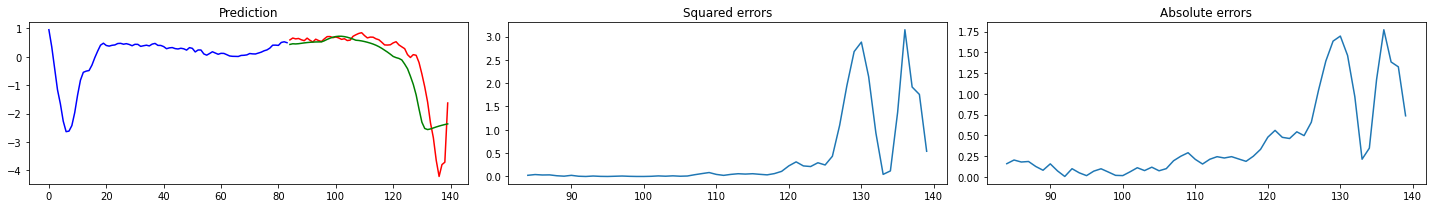

(TDI, TDM):  (0.1846301020408163, -0.4127806563039723)


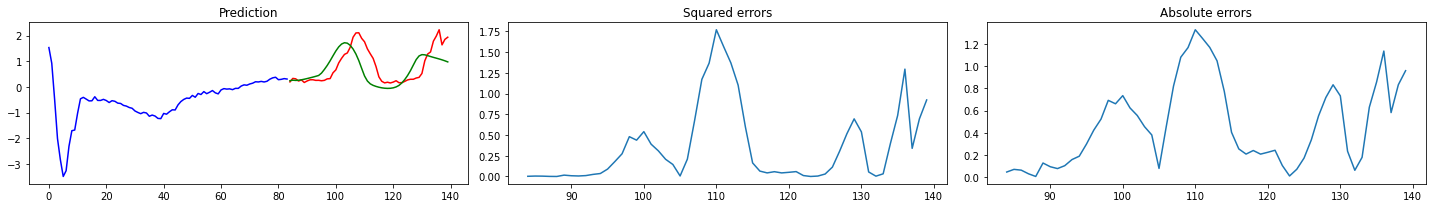

(TDI, TDM):  (0.1214923469387755, -0.9212598425196851)


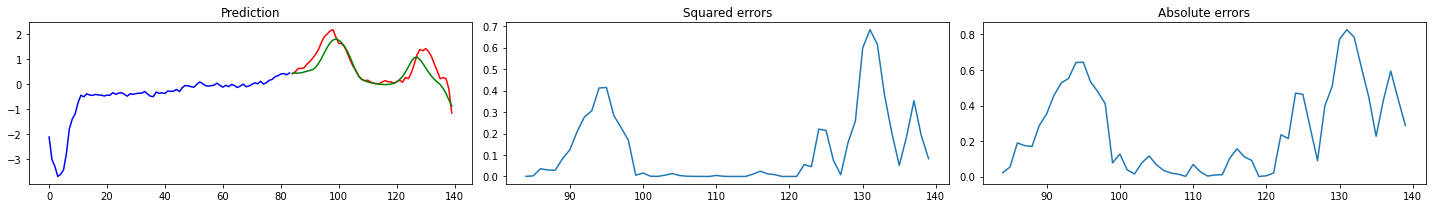

(TDI, TDM):  (0.07302295918367346, 0.17030567685589526)


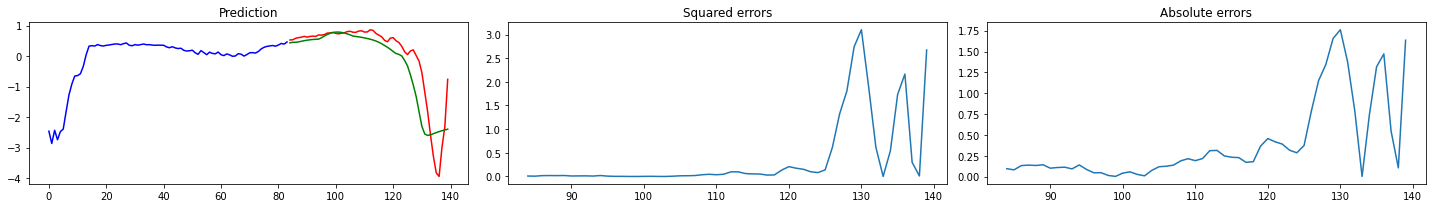

(TDI, TDM):  (0.18718112244897958, -0.5468483816013628)


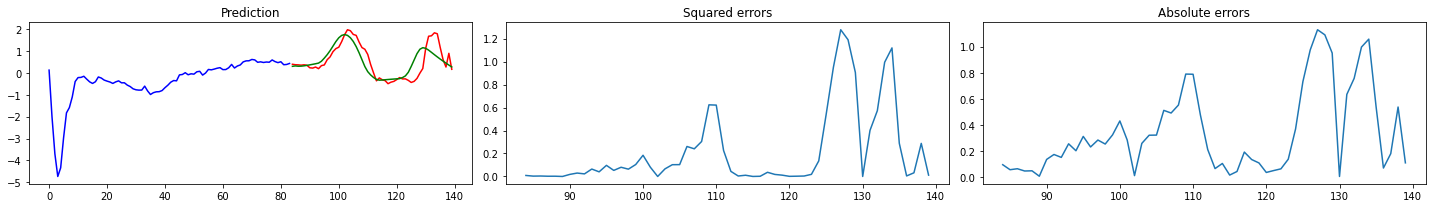

(TDI, TDM):  (0.11575255102040816, -1.0)


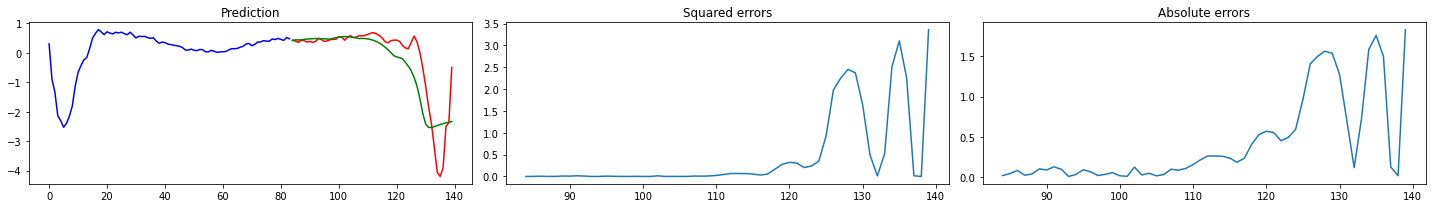

(TDI, TDM):  (0.2075892857142857, -1.0)


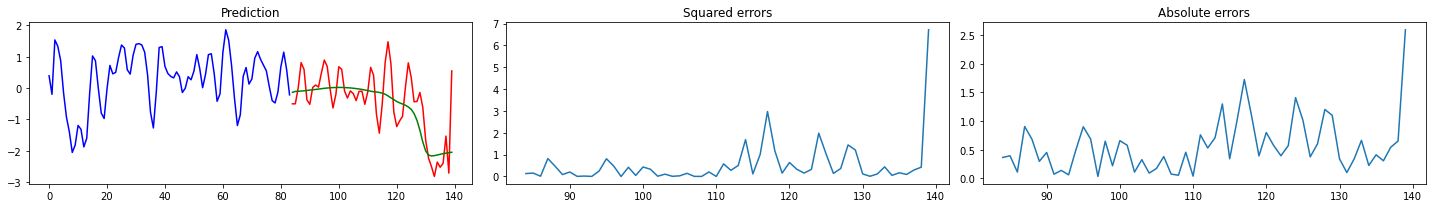

(TDI, TDM):  (0.1568877551020408, 0.47560975609756095)


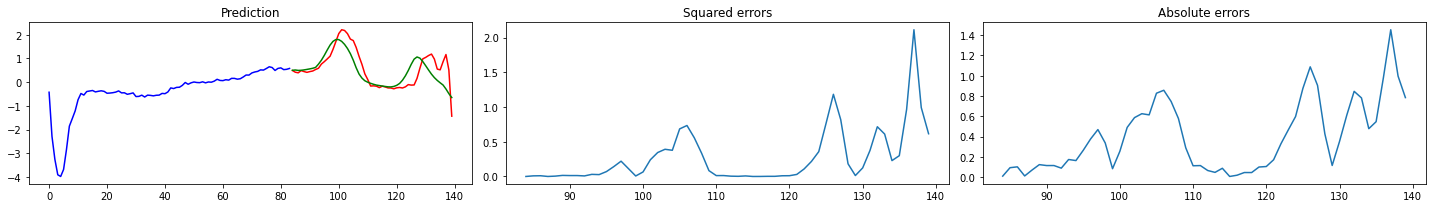

(TDI, TDM):  (0.09693877551020408, -0.8289473684210527)


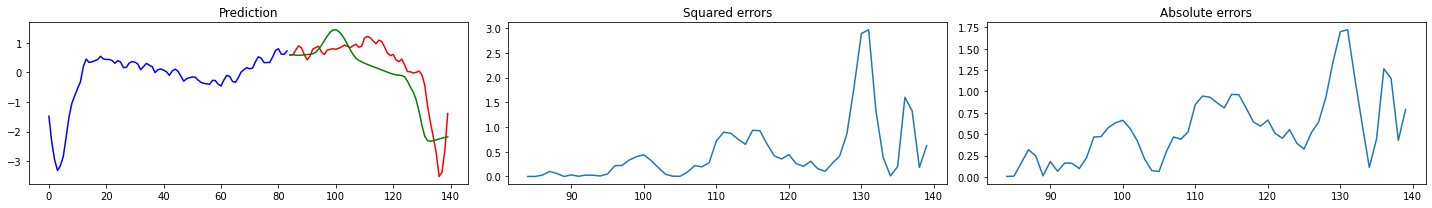

(TDI, TDM):  (0.25956632653061223, -0.8157248157248157)


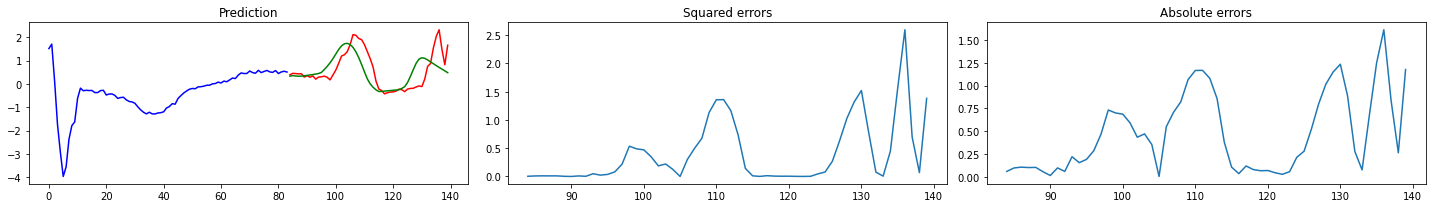

(TDI, TDM):  (0.14190051020408162, -1.0)


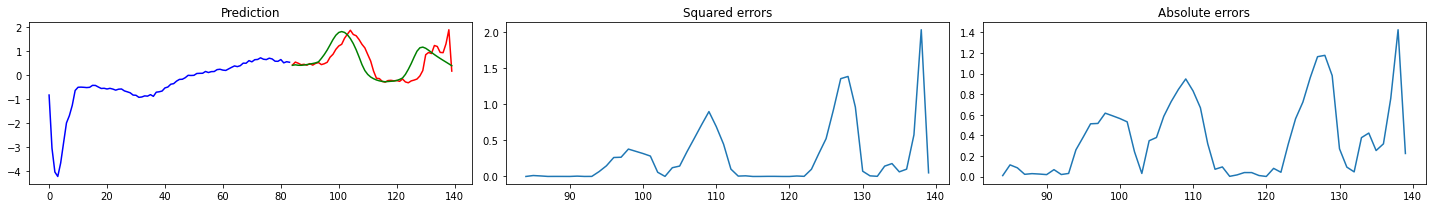

(TDI, TDM):  (0.12978316326530612, -0.828009828009828)


In [5]:
predict_on_batch(gru_net, ecg_test_loader, n=16)

# Seq2seq on Traffic

DILATE GRU: 100%|███████████████████████████████████████████████| 20/20 [09:52<00:00, 29.61s/epoch, train_loss=3.06e-5]


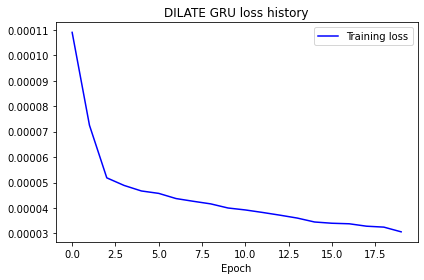

In [6]:
# Parameters
window = 24
horizon = 24
batch_size = 32
epochs = 20
lr = 0.01
 
# Load data
ds = Traffic("./data/mvdata/traffic.txt", 24, 24, usecol=0)
traffic_train, traffic_test = split_dataset(ds, 0.2)
traffic_train_loader = torch.utils.data.DataLoader(traffic_train, batch_size=batch_size, shuffle=True, drop_last=True)
traffic_test_loader = torch.utils.data.DataLoader(traffic_test, batch_size=batch_size, shuffle=True, drop_last=True)

# Build model
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, fc_units=16, output_size=1).to(device)
gru_net = NetGRU(encoder, decoder, horizon, device).to(device)
optimizer = torch.optim.Adam(gru_net.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

# Train
train_model(gru_net, optimizer, loss_fn, traffic_train_loader, epochs=epochs)

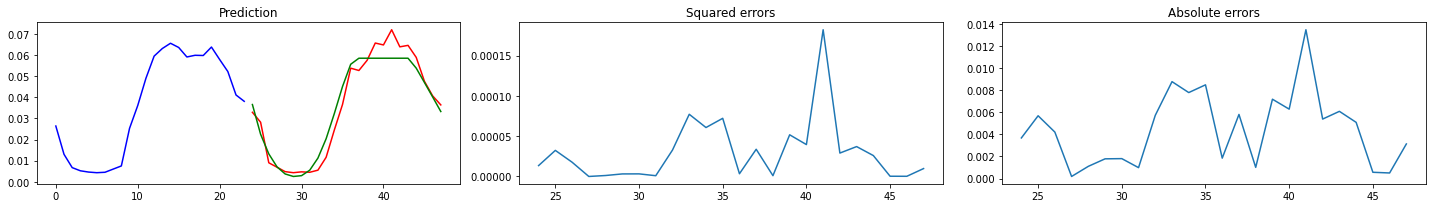

(TDI, TDM):  (0.043402777777777776, -0.76)


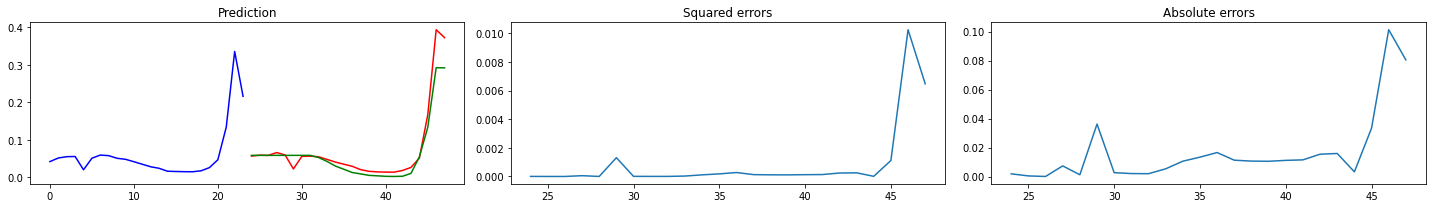

(TDI, TDM):  (0.10243055555555555, 0.0847457627118644)


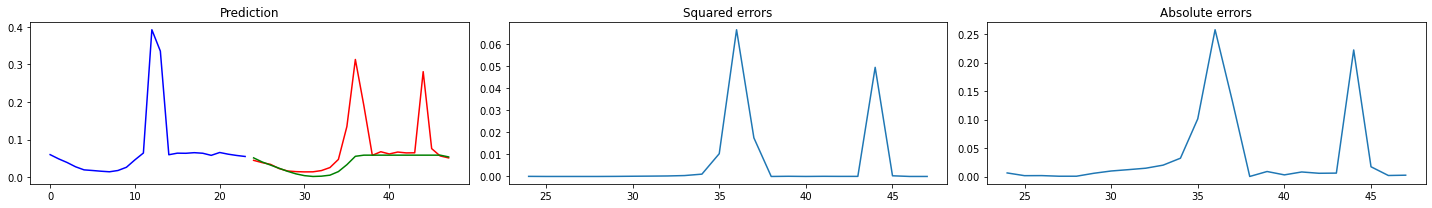

(TDI, TDM):  (0.05208333333333333, 0.8)


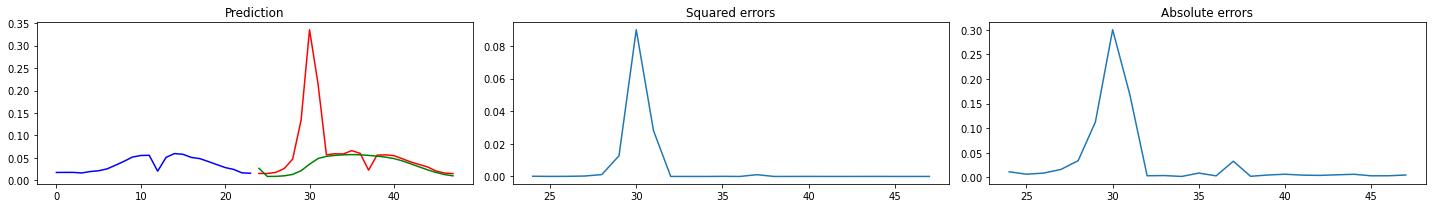

(TDI, TDM):  (0.1597222222222222, 0.673913043478261)


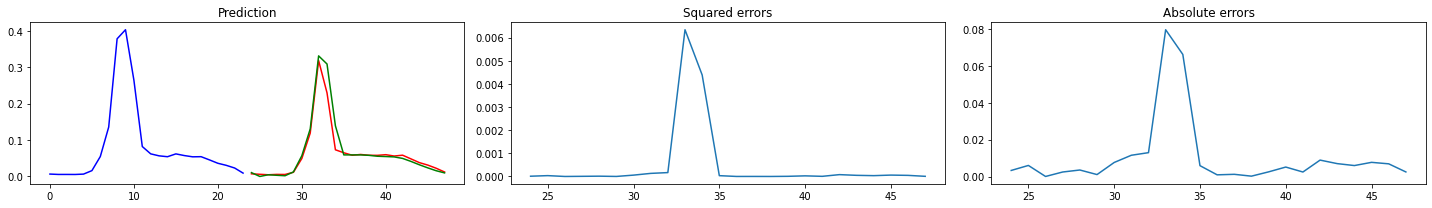

(TDI, TDM):  (0.043402777777777776, -0.6)


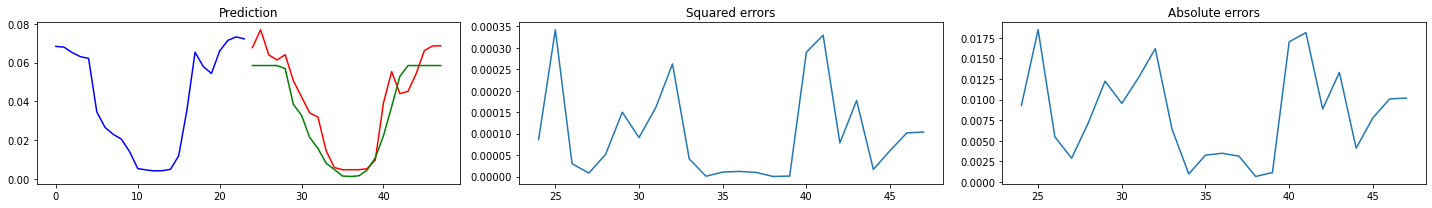

(TDI, TDM):  (0.05555555555555555, -0.6875)


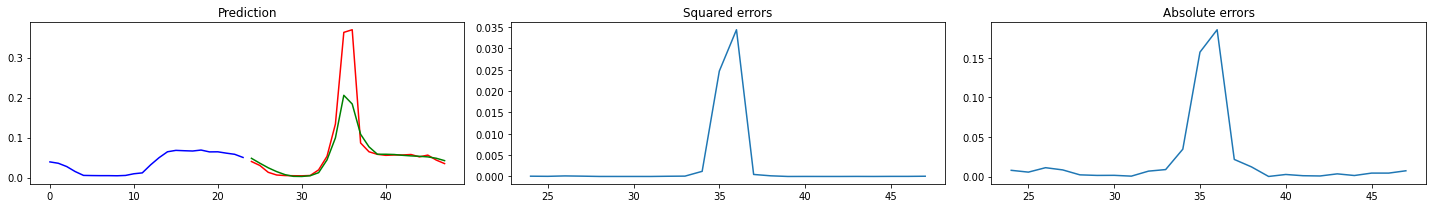

(TDI, TDM):  (0.048611111111111105, 0.7857142857142858)


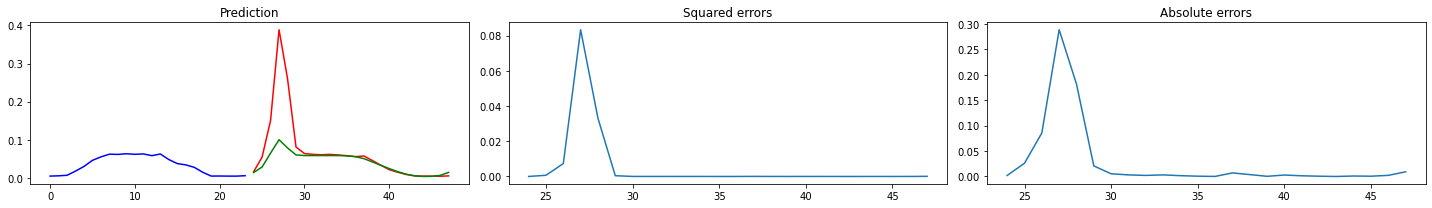

(TDI, TDM):  (0.08680555555555555, -0.8)


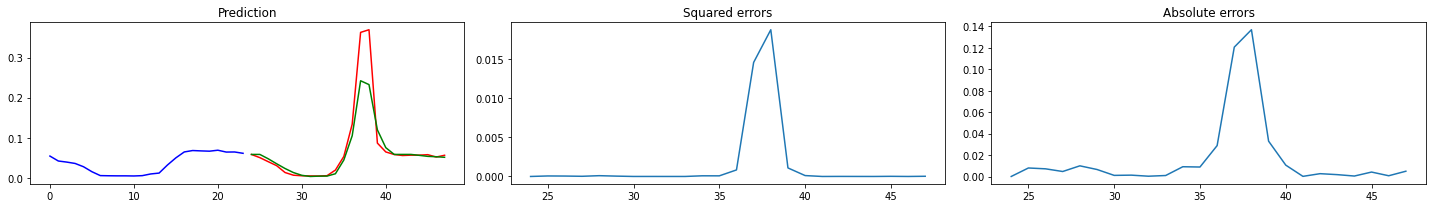

(TDI, TDM):  (0.03819444444444444, 0.7272727272727273)


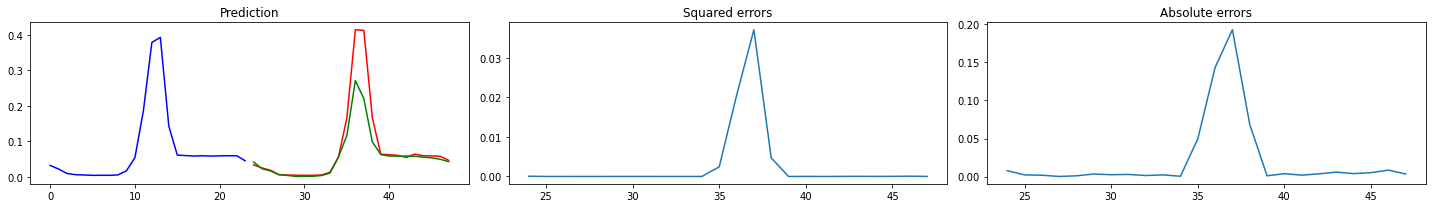

(TDI, TDM):  (0.078125, -0.8666666666666667)


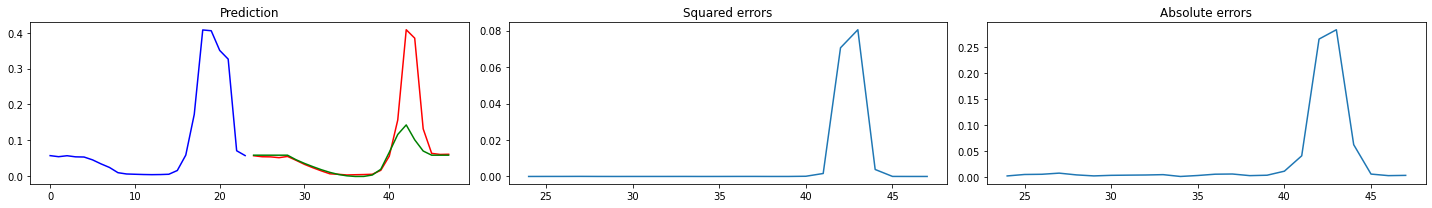

(TDI, TDM):  (0.026041666666666664, 0.06666666666666665)


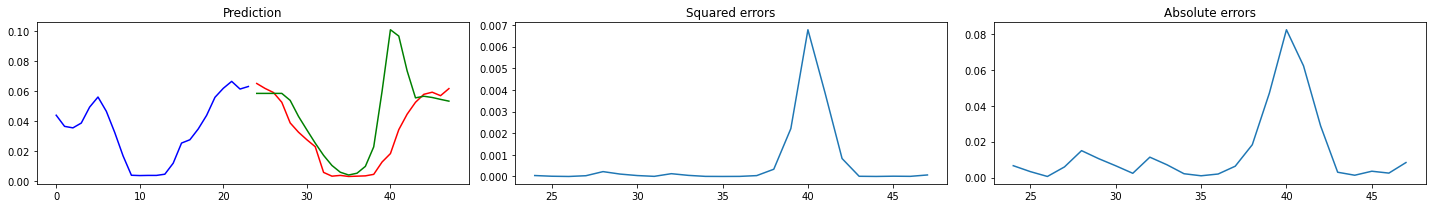

(TDI, TDM):  (0.1753472222222222, -0.6039603960396039)


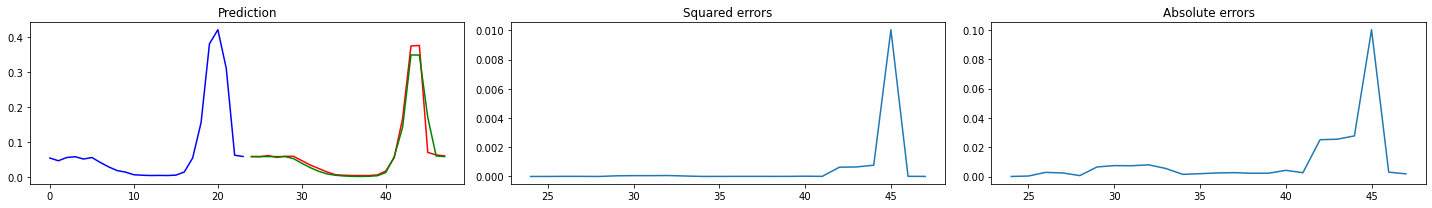

(TDI, TDM):  (0.043402777777777776, -1.0)


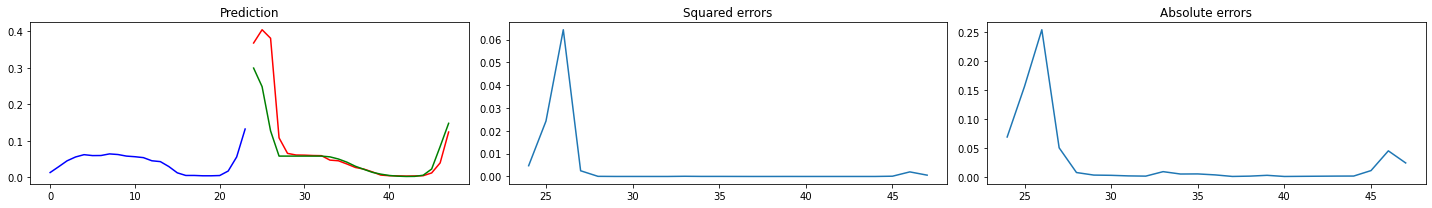

(TDI, TDM):  (0.043402777777777776, -0.6)


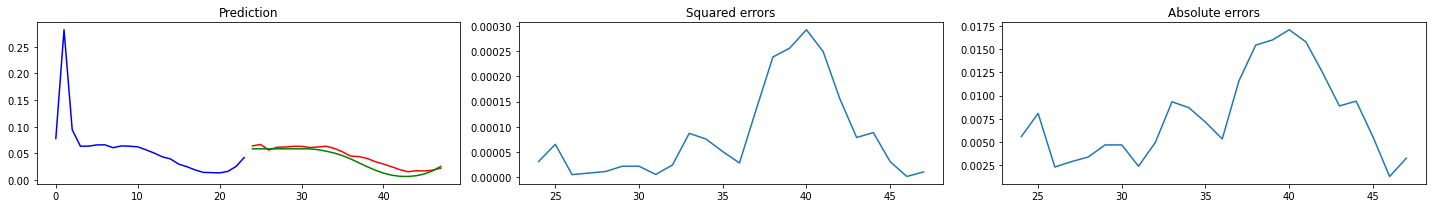

(TDI, TDM):  (0.14583333333333331, -0.8095238095238095)


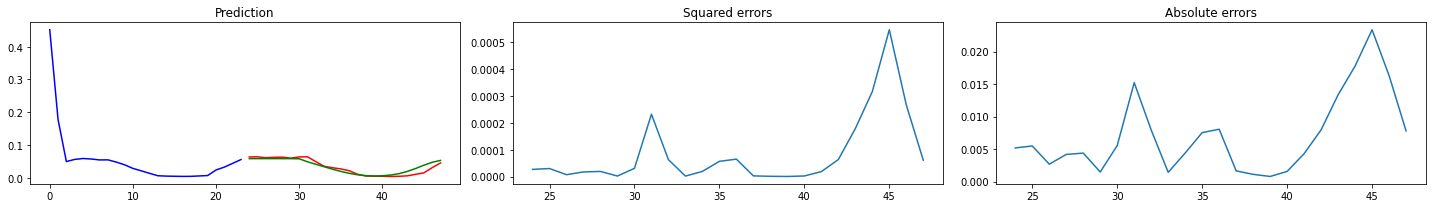

(TDI, TDM):  (0.10069444444444443, -1.0)


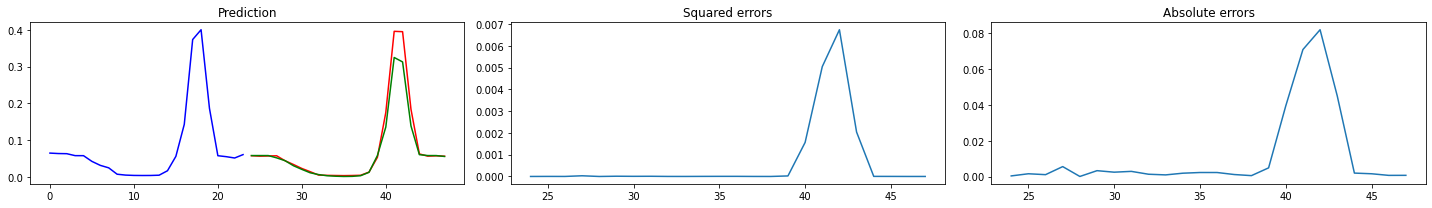

(TDI, TDM):  (0.010416666666666666, 0.0)


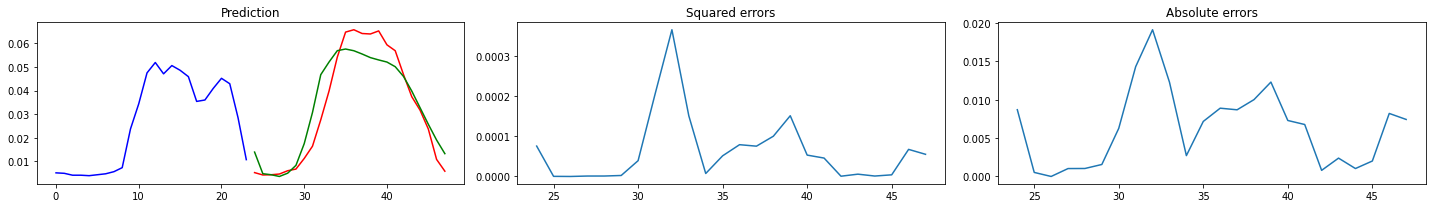

(TDI, TDM):  (0.09722222222222221, -0.6428571428571428)


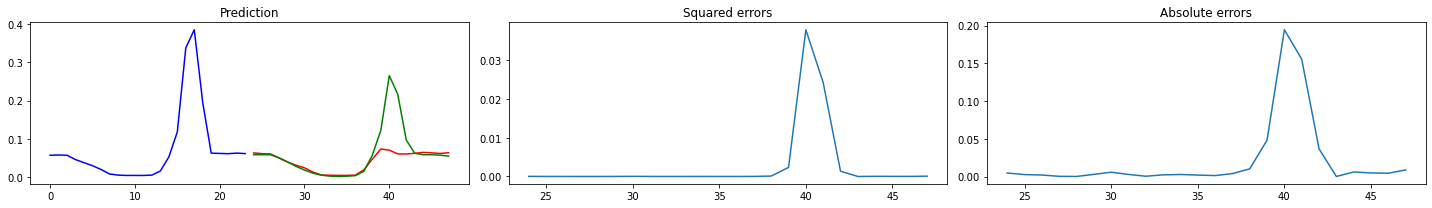

(TDI, TDM):  (0.04513888888888889, 0.15384615384615374)


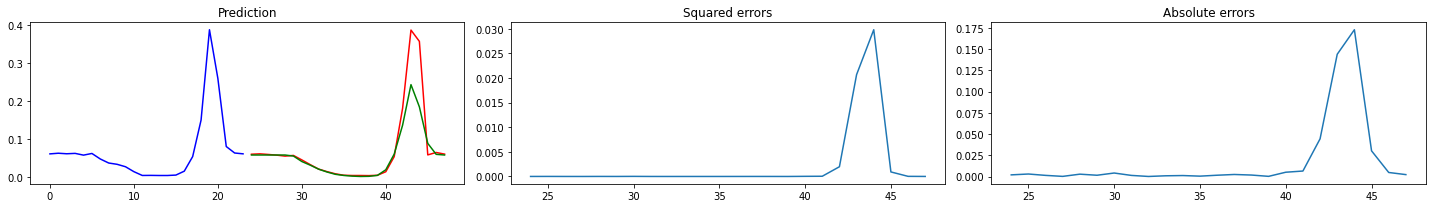

(TDI, TDM):  (0.03125, -0.6666666666666667)


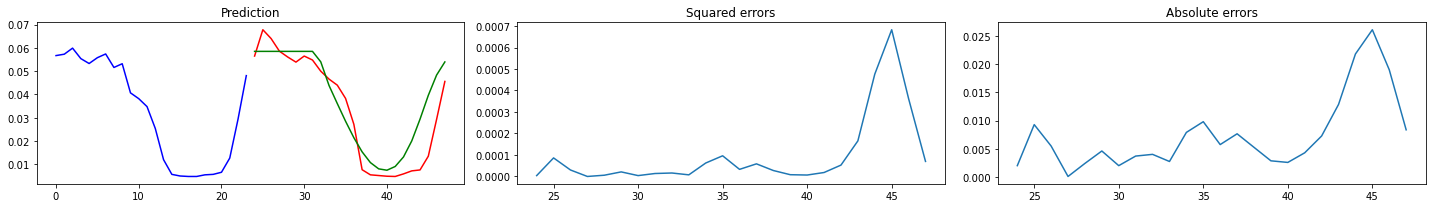

(TDI, TDM):  (0.11458333333333333, -0.030303030303030276)


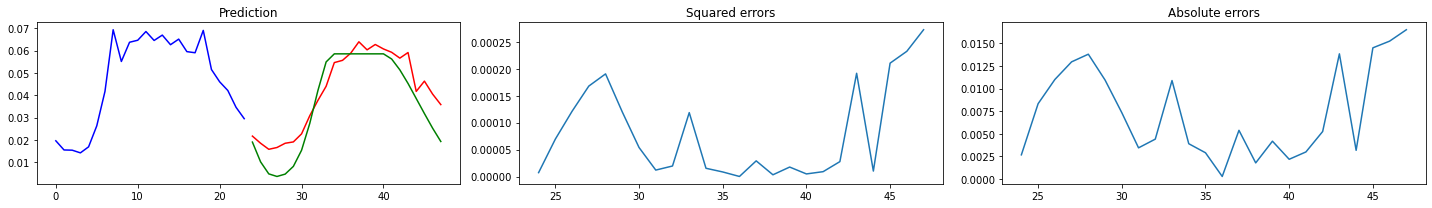

(TDI, TDM):  (0.09895833333333333, -0.4035087719298246)


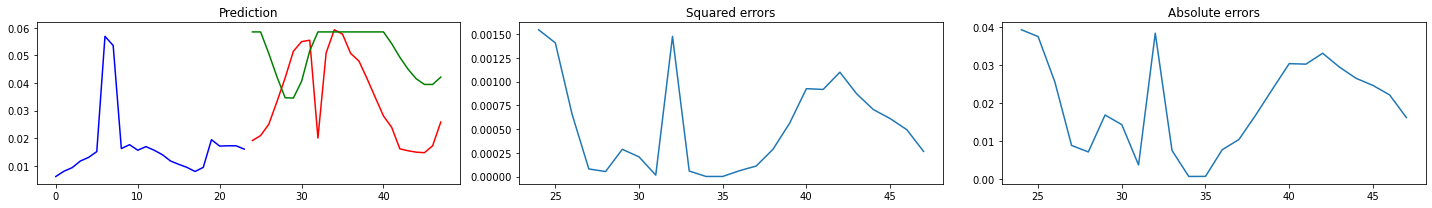

(TDI, TDM):  (0.24652777777777776, 0.5211267605633803)


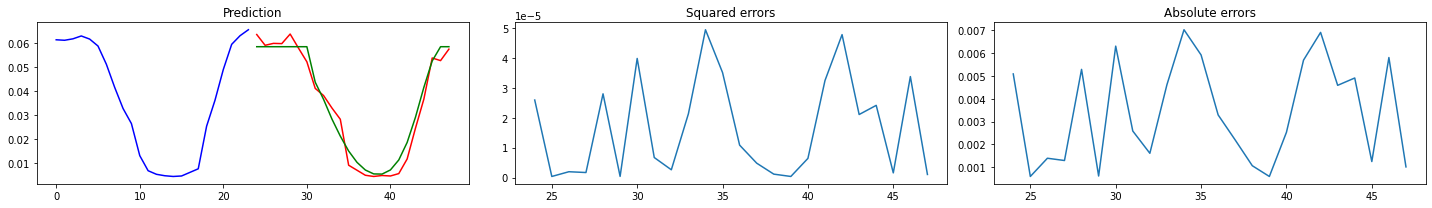

(TDI, TDM):  (0.034722222222222224, -0.30000000000000004)


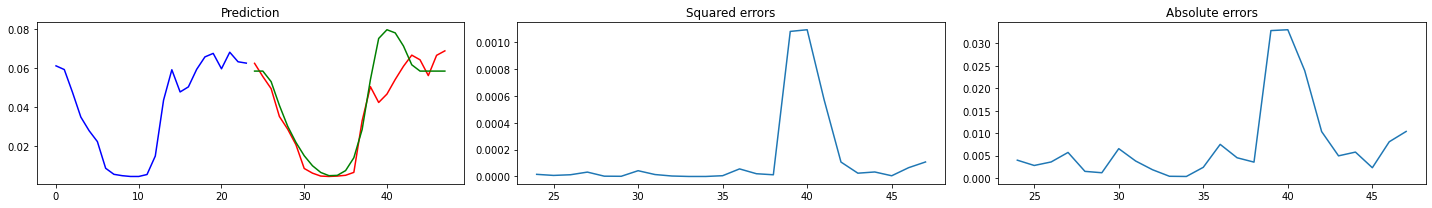

(TDI, TDM):  (0.06944444444444445, -0.65)


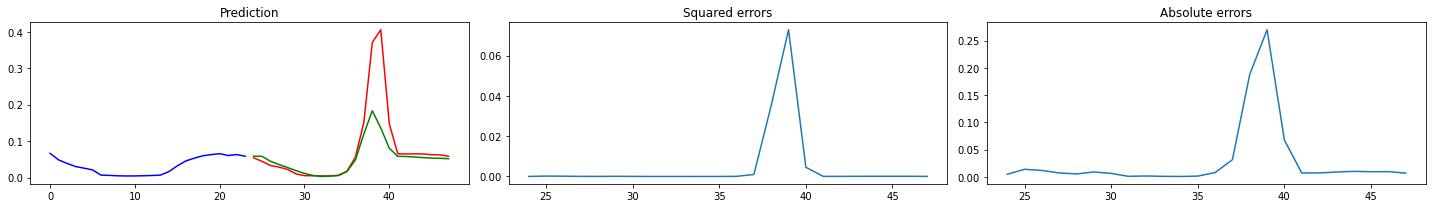

(TDI, TDM):  (0.09375, -0.5185185185185186)


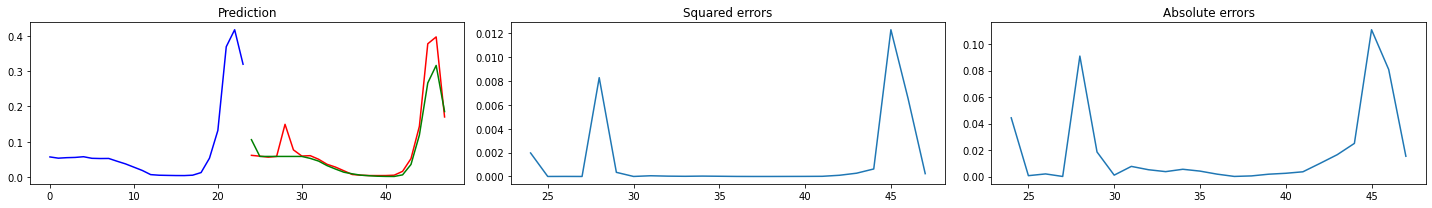

(TDI, TDM):  (0.03125, -0.4444444444444444)


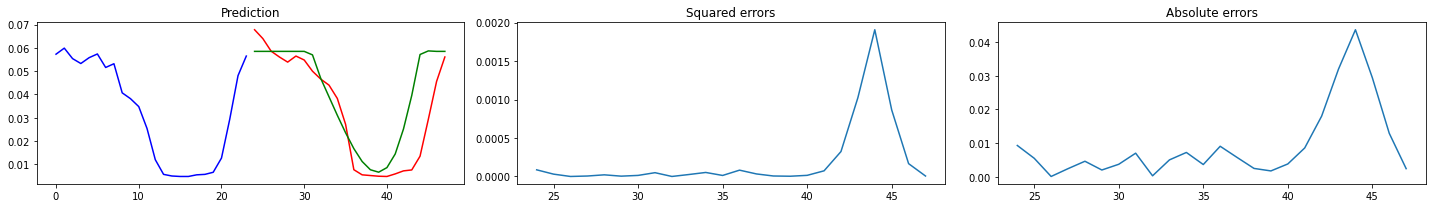

(TDI, TDM):  (0.13541666666666666, -0.1282051282051282)


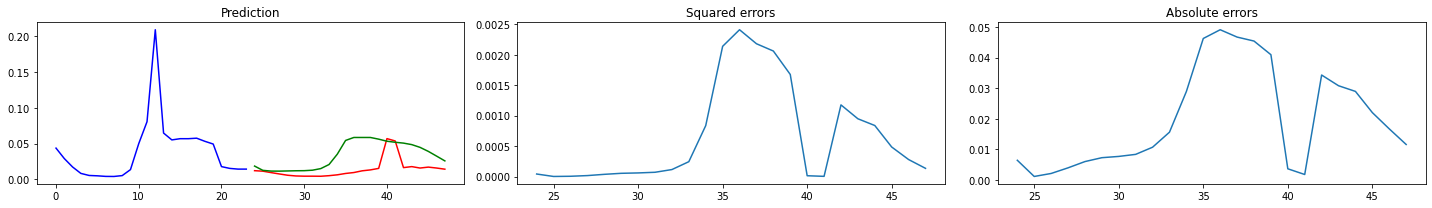

(TDI, TDM):  (0.3055555555555555, -0.5795454545454546)


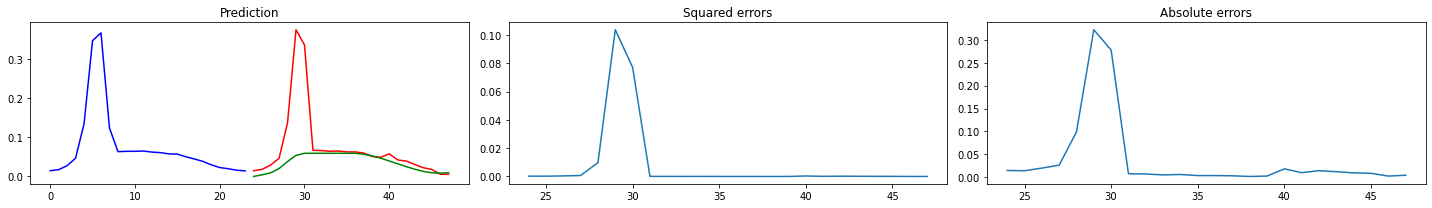

(TDI, TDM):  (0.0798611111111111, -0.13043478260869568)


In [7]:
predict_on_batch(gru_net, traffic_test_loader, 30)